# VGGnet과 그 구조

VGGnet은 이미지 분류 CNN 모델 중 하나.
VGGNet의 개발자들은 모델의 깊이가 성능에 얼마나 영향을 끼칠지에 집중하여 연구하였다고 논문에서 밝혔다.<br>
깊이에 따른 변화를 비교하기 위해, 3x3의 작은 필터 크기를 사용했고, 모델 깊이와 구조에 변화를 주어 실험하였다. 
<br>논문에서 언급한 것은 총 6개의 모델이고, 사진은 "D" 구조의 VGG16, "E" 구조의 VGG19다. 숫자가 의미하는 것이 층의 수<br>
*다른 사진은 vgg19 256에서 레이어가 4개고 vgg16의 경우 3갠데, 그게 숫자가 맞지 않나?*

**All conv are 3x3 stride 1 padding 1** : conv 뒤에 숫자가 특성맵 수
<br> **All Max Poolings are 2x2 stride 2**
<br>**After pooling, double the number of channels <br> Use only conv/max pool/fully connected layers** : fully connected layer를 일반적인 뉴럴네트워크라고 생각하면 되겠다

<img src='https://media5.datahacker.rs/2018/11/vgg-ispravljeno-.png' style="zoom:20%;" />

### 잠깐 용어 복습

- Filter: 특징을 추출해줌 <br>
- Activation Function: 필터의 값을 비선형으로 바꿔줌. 이렇게 두개가 conv layer 구조 <br> 

- Padding: 결과값이 작아지지 않도록 패딩하여 특징의 유실을 막음 <br>
- Pooling: conv 레이어 거쳐 특징이 추출되면, 모든 특징을 갖고 판단할 필요는 없다. 그래서 activation map을 줄이는 작업이 바로 pooling. <br> 출처: https://bcho.tistory.com/1149

### VGG의 3x3 필터 크기의 convolution 연산은 어떤 의미가 있을까?<br>

3x3 conv 두 번 쌓는 것 = 5x5 conv와 동일한 receptive field의 정보를 처리 
<br> 3x3 conv 세 번 쌓는 것= 7x7과 동일한 receptive field의 정보를 처리. 하지만, 3x3을 여러번 쌓는 것이 더 좋은 성능을 낸다. 
<br>
<br>1) 3x3 convolution 연산을 여러번 하는 것은 여러 번의 비선형 처리를 해주는 것이므로, 큰 필터로 한번 연산 했을 때보다 더 많은 비선형성을 가질 수 있음 <br> 2) 파라미터 수는 3x3 convolution 여러번 했을 때가 더 적다. CNN에서 가중치는 모두 훈련이 필요한 것들로, 가중치가 적다는 것은 그만큼 훈련시킬 것의 개수가 작아진다는 뜻이고, 따라서 학습속도가 빨라진다.

### 단점이 있다면?

VGGNet은 간단한 구조를 가졌지만, fully connected layer가 3개가 있고, 풀링을 거친 뒤에는 피쳐맵의 갯수가 2배로 커지면서 필요한 파라미터가 과도하게 많아졌다. 파라미터가 많다는 것은 딥러닝의 고질적인 문제인, gradient vanishing, 과적합등의 문제가 발생할 가능성이 크다는 의미.

# VGG 19 : Cifar 10

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import warnings  
warnings.filterwarnings(action='ignore')

In [2]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

In [3]:
#import inspect 
#print(inspect.getsource(torchvision.models.Resnet))

In [2]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num, Y=loss_value, win = loss_plot, update='append')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), #데이터 폼 텐서로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #정규화

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, #배치 사이즈 512 (2의 9승) 
                                          #suffle true는 모델이 데이터셋 순서에 익숙해짐을 방지하기 위하여, 학습때만 부여
                                          shuffle=True, num_workers=0) #num workers: cpu 멀티 프로세스 값. 디폴트 0 => 메인프로세스만

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Cifar 데이터는 비행기, 새, 말, 트럭 등 총 10개의 대분류가 있고, 각 대분류에 10개의 소분류가 있어서 총 100개의 label이 있다. 
<br> 또한 Cifar는 컬러 데이터로 RGB의 3개의 채널이 있다. 
<br> 그 중 Cifar 10는 대분류로 labeling을 해둔 데이터다. 

https://jybaek.tistory.com/799 : numworkers 참고

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

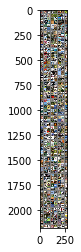

truck   dog horse truck


In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
#dataiter = iter(trainloader)
#images, labels = dataiter.next()
#vis.images(images/2 + 0.5)

# show images 
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
import torchvision.models.vgg as vgg

In [11]:
cfg = [32,32,'M',64,64,'M',128,128,128,128,'M',256,256,256,256,'M',512,512,512,512,'M']

In [12]:
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096), #맥스풀링 5번 하면 32 => 16 8 4 2 1
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),) #얘네가 세번 붙는 fully connected layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)# 첫번째 차원인 배치 차원은 그대로 두고 나머지는 펼쳐라
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') #입력신호 수 제한,,,?이래여
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [13]:
vgg19= VGG(vgg.make_layers(cfg),10,True).to(device) #10은 클래스 갯수를 의미

In [14]:
a=torch.Tensor(1,3,32,32).to(device) # 배치 크기 × 채널 × 높이(height) × 너비(widht)의 크기의 텐서를 선언
out = vgg19(a)
print(out)

tensor([[ 0.0020, -0.0031,  0.0006, -0.0004,  0.0018, -0.0004, -0.0017, -0.0026,
          0.0015, -0.0014]], grad_fn=<AddmmBackward>)


In [14]:
criterion = nn.CrossEntropyLoss().to(device) #loss ftn 설정
optimizer = torch.optim.SGD(vgg19.parameters(), lr = 0.005,momentum=0.9)

#lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 
#for epoch 및에 쓸거고 스텝 5마다 러닝 레이트 값에 0.9를 곱하라는 뜻인데 우린 에포크 2번 돌거라서 안해도 됨

In [15]:
#make plot
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

### Training

In [16]:
print(len(trainloader))
epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    #lr_sche.step() 
    for i, data in enumerate(trainloader, 0):
        # get tue inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 ==29:
            print('[%d, %5d] loss: %.5f' % (epoch + 1, i + 1, running_loss/30))
            running_loss = 0.0

print('Finished Training')

98
[1,    30] loss: 2.30261
[1,    60] loss: 2.30258
[1,    90] loss: 2.30260
[2,    30] loss: 2.30250
[2,    60] loss: 2.30252
[2,    90] loss: 2.30247
Finished Training


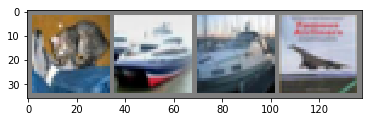

GroundTruth:    cat  ship  ship plane


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
outputs = vgg19(images.to(device))

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4))) #그렇구나,,,

Predicted:    dog   car   dog  bird


# Resnet의 구조

망이 깊으면 무조건 좋을까? ResNet은 네트워크를 얼마나 깊게 쌓을 수 있을까라는 의문에서 시작되었다. 
<br>이제까지 모델들의 경우 일정 수준 이상이면 깊이가 얕은 모델보다 깊은 모델의 성능이 더 떨어졌다. 
<br>이는 이미 여러 번 언급되었던 vanishing / exploding gradient 문제 때문. 그렇다면 어떻게 해야 망이 깊을 때 효과를 볼 수 있을까? 새로운 방법이 필요하다. 

### Residual Block

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbFPOry%2FbtqzR2En9ry%2F2DTETgT1BkCrW74hKQCsrk%2Fimg.png" style="zoom:40%;"/>

이 고민이 바로 ResNet의 핵심인 Residual Block의 출현을 가능케 했다. 위 그림에서 오른쪽이 Residual Block을 나타낸다. 
<br>기존 망과의 차이는 입력값을 출력값에 더해줄 수 있도록 지름길(shortcut)을 하나 만들어준 것 뿐이다. 
- 기존의 신경망은 입력값 x를 타겟값 y로 매핑하는 함수 H(x)를 얻는 것이 목적이었다. 
- 그러나 ResNet은 F(x) + x를 최소화하는 것을 목적으로 한다. x는 현시점에서 변할 수 없는 값이므로 F(x)를 0에 가깝게 만드는 것이 목적이 된다. F(x)가 0이 되면 출력과 입력이 모두 x로 같아지게 된다. 
- F(x) = H(x) - x이므로 F(x)를 최소로 해준다는 것은 H(x) - x를 최소로 해주는 것과 동일한 의미를 지닌다. 
- 여기서 H(x) - x를 잔차(residual)라고 한다. 즉, 잔차를 최소로 해주는 것이므로 ResNet이란 이름이 붙게 된다. 

*ResNet의 original 논문에 의하면 경험적으로(empirically) 입력과 출력이 같아지도록 놓고 학습을 시켰더니 더 좋은 결과가 나왔다고 한다.* 
https://bskyvision.com/644

### Resnet의 구조

ResNet은 VGG19의 구조를 뼈대로 convolution층을 추가해서 깊게 만든 후에, shortcut들을 추가하는 것이 전부다. 
<br>34층의 ResNet과 거기에서 shortcut들을 제외한 버전인 plain 버전 네트워크와, 그 옆에 추가한 버전.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbdQ7nn%2FbtqzVCKyKVV%2F5nkGhNvCqK9BcIgasYRxH0%2Fimg.jpg" style="zoom:66%;"/>


위 그림을 보면 알 수 있듯이 ResNet34는 처음을 제외하고는 균일하게 3 x 3 사이즈의 convolution 필터를 사용했다. 
<br>그리고 특성맵의 사이즈가 반으로 줄어들 때, 특성맵의 뎁스(피쳐맵의 수)를 2배로 높였다. 
<br> 성능을 비교해보면, ResNet은 망이 깊어지면서 에러도 역시 작아졌다! shortcut을 연결해서 잔차(residual)를 최소가 되게 학습한 효과가 있다는 것이다. 밑에서 flop은 곱하기 연산 수인데, vgg19보다 훨씬훨씬 덜한다고 함

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzwdXd%2FbtqzVoeJwoE%2F9oMcs2Qkj5m07pKPHRmeK0%2Fimg.png">

ResNet의 CIFAR-10에서의 성능을 살펴보기 전에 하나 알아야할 것이 있다. ResNet의 깊이가 점점 깊어지면 parameter의 수가 너무 많아지기 때문에 residual block으로 다른 구조를 사용한다. 
<br> Residual block의 원래 구조는 아래 그림의 왼쪽과 같다. 50층 이상인 ResNet에서는 오른쪽 그림과 같은 residual block을 사용한다. 1x1 convolution을 통해 filter size를 줄인 이후에 3x3 convolution을 하면 파라미터의 수를 아낄 수 있다. 이러한 구조의 residual block을 bottelnet block이라고 부른다. Bottleneck 구조를 사용해 ResNet의 내부 구조를 바꾸면 152 layer까지 쌓아도 vgg보다 모델 크기가 작다. https://dnddnjs.github.io/cifar10/2018/10/09/resnet/

<img src="https://www.dropbox.com/s/blbivxvl6kjllfn/Screenshot%202018-11-18%2021.31.58.png?dl=1">

# Resnet 34: Cifar10

block은 BasicBlock 사용하고, layer는 ResNet50처럼 [3, 4, 6, 3] 사용

In [1]:
import torch
import torch.nn as nn

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [2]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

Setting up a new session...


''

In [14]:
def value_tracker(value_plot, value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=value,
             win = value_plot,
             update='append')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)

print(trainset.data.shape)

train_data_mean = trainset.data.mean( axis=(0,1,2) )
train_data_std = trainset.data.std( axis=(0,1,2) )
#데이터셋 가져와서 각 축에 대한 mean과 std를 계산, 255로 나누어준다. 

print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255
train_data_std = train_data_std / 255

print(train_data_mean)
print(train_data_std)

Files already downloaded and verified
(50000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #데이터셋을 다양하게 가져오겠다
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import torchvision.models.resnet as resnet

In [7]:
BasicBlock= resnet.BasicBlock

conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck

In [8]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) #사이즈 작아서 뺌
        
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        #x.shape =[batch, 3, 32,32]
        x = self.conv1(x)
        #x.shape =[1, 16, 32,32]
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.maxpool(x)

        x = self.layer1(x)
        #x.shape =[1, 128, 32,32]
        x = self.layer2(x)
        #x.shape =[1, 256, 32,32]
        x = self.layer3(x)
        #x.shape =[1, 512, 16,16]
        x = self.layer4(x)
        #x.shape =[1, 1024, 8,8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [9]:
resnet34 = ResNet(resnet.BasicBlock, [3, 4, 6, 3], 10, True).to(device) 
#=> 2*(3+4+6+3) +(conv1) +1(fc) = 32+2 = 34

In [10]:
a=torch.Tensor(1,3,32,32).to(device)
out = resnet34(a)
print(out)

tensor([[-0.0196, -0.0132, -0.0700,  0.0751,  0.0726, -0.0021,  0.0627, -0.0392,
          0.0873, -0.0145]], grad_fn=<AddmmBackward>)


In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet34.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 5e-4)
#lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [12]:
#make plot
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))
acc_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='Accuracy', legend=['Acc'], showlegend=True))

In [15]:
print(len(trainloader))
epochs = 2

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet34(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 29:    # print every 30 mini-batches
            value_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 30))
            running_loss = 0.0


print('Finished Training')

196
[1,    30] loss: 1.902
[1,    60] loss: 1.784
[1,    90] loss: 1.685
[1,   120] loss: 1.630
[1,   150] loss: 1.561
[1,   180] loss: 1.483
[2,    30] loss: 1.381
[2,    60] loss: 1.267
[2,    90] loss: 1.234
[2,   120] loss: 1.189
[2,   150] loss: 1.133
[2,   180] loss: 1.060
Finished Training
